## EBOV deconvolution in Pyro N-order




```
Indices:

- c cell type
- g genes
- m samples
- n sample in batch
- k deformation polynomial degree
- i individual
```

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import torch
import pyro
from pyro.infer import SVI, Trace_ELBO

device = torch.device("cpu:0")
dtype = torch.float32
dtype_np = np.float32

## Configuration

In [2]:
data_path = "/home/nbarkas/disk3/ebov_bulk_rna_seq/proc_20210524/18-CompositionDeconvolution/03-previous_pyro_decov/deconvolution/data/load_data_python"

In [3]:
from typing import List, Dict
from boltons.cacheutils import cachedproperty


class EBOVDataset:
    
    def __init__(
            self,
            data_path: str,
            dtype_np: np.dtype):
        
        self.dtype_np = dtype_np
        
        # load all data
        self.bulk_raw_gex_gm = np.load(os.path.join(data_path, 'bulk_matrix.npy')).astype(dtype_np)
        
        with open(os.path.join(data_path, 'bulk_pdata.pkl'), 'rb') as f:
            loader = pickle.Unpickler(f)
            self.bulk_sample_metadata_pd = loader.load()

        self.sc_raw_gex_gj = np.load(os.path.join(data_path, 'sc_matrix.npy'))

        with open(os.path.join(data_path, 'sc_pdata.pkl'), 'rb') as f:
            loader = pickle.Unpickler(f)
            self.sc_sample_metadata_pd = loader.load()
            
        # shorthands
        self.num_samples = self.bulk_raw_gex_gm.shape[-1]
        self.num_genes = self.bulk_raw_gex_gm.shape[-2]
        self.num_individuals = len(set(self.bulk_sample_metadata_pd['id.individual'].values))
        
        # index individuals
        individual_str_list = sorted(list(set(self.bulk_sample_metadata_pd['id.individual'].values)))
        individual_str_to_index_map = {
            individual_str: index for index, individual_str in enumerate(individual_str_list)}
        
        # individual index of each sample
        self.m_to_i = np.asarray(list(
            map(
                individual_str_to_index_map.get,
                self.bulk_sample_metadata_pd['id.individual'].values)))
        
        # pre-process dpi times
        self.dpi_time_m = np.clip(
            self.bulk_sample_metadata_pd['dpi_time'].values.astype(dtype_np),
            a_min=0., a_max=None)
        self.dpi_time_m = self.dpi_time_m / self.dpi_time_m.max()

    @cachedproperty
    def cell_type_str_list(self) -> List[str]:
        return sorted(list(set(self.sc_sample_metadata_pd['Subclustering_reduced'])))

    @cachedproperty
    def cell_type_str_to_index_map(self) -> Dict[str, int]:
        return {cell_type_str: index for index, cell_type_str in enumerate(self.cell_type_str_list)}        

    @cachedproperty
    def num_cell_types(self) -> int:
        return len(self.cell_type_str_list)
    
    @cachedproperty
    def w_hat_gc(self) -> np.ndarray:
        w_hat_gc = np.zeros((self.num_genes, self.num_cell_types))
        for cell_type_str in self.cell_type_str_list:
            i_cell_type = self.cell_type_str_to_index_map[cell_type_str]
            mask_j = self.sc_sample_metadata_pd['Subclustering_reduced'].values == cell_type_str
            w_hat_gc[:, i_cell_type] = np.sum(self.sc_raw_gex_gj[:, mask_j], axis=-1)
            w_hat_gc[:, i_cell_type] = w_hat_gc[:, i_cell_type] / np.sum(w_hat_gc[:, i_cell_type])
        return w_hat_gc

In [4]:
ebov_dataset = EBOVDataset(data_path, dtype_np)

In [5]:
from typing import Dict

def generate_minibatch(
        dataset: EBOVDataset,
        minibatch_size: int,
        device: torch.device,
        dtype: torch.dtype,
        return_full_batch: bool = False) -> Dict[str, torch.Tensor]:
    """
    
    TODO: balanced sampling from time
    
    """
    
    # choose random samples
    if return_full_batch:
        sample_indices_n = np.arange(dataset.num_samples)
    else:
        sample_indices_n = np.random.randint(0, dataset.num_samples, size=minibatch_size)
    
    # subset data
    x_ng = dataset.bulk_raw_gex_gm[:, sample_indices_n].T
    t_n = dataset.dpi_time_m[sample_indices_n]
    ind_index_n = dataset.m_to_i[sample_indices_n]
    
    return {
        'x_ng': torch.tensor(x_ng, device=device, dtype=dtype),
        't_n': torch.tensor(t_n, device=device, dtype=dtype),
        'ind_index_n': torch.tensor(ind_index_n, device=device, dtype=torch.long),
        'sample_index_n': torch.tensor(sample_indices_n, device=device, dtype=torch.long)
    }

In [6]:
from pyro.distributions.torch_distribution import TorchDistribution, TorchDistributionMixin
from torch.distributions.utils import probs_to_logits, logits_to_probs, broadcast_all, lazy_property
from torch.distributions import constraints
from numbers import Number

def NegativeBinomialAltParam(mu, phi):
    r"""
    Creates a negative binomial distribution.
    
    Args:
        mu (Number, Tensor): mean (must be strictly positive)
        phi (Number, Tensor): overdispersion (must be strictly positive)
    """
    return dist.GammaPoisson(
            concentration= 1 /phi ,
            rate=1 / (mu * phi))

In [7]:
import pyro.distributions as dist


class PseudoTimeRegDeconvolution:
    """
    
    .. note: we use "n" for batch dimension, and "m" for sample index.
    .. note: for polynomial degree use k
    
    """
    
    def  __init__(
            self,
            dataset: EBOVDataset,
            polynomial_degree: int,
            device: device,
            dtype: dtype):
        
        self.dataset = dataset
        self.device = device
        self.dtype = dtype
        self.polynomial_degree = polynomial_degree
        
        # hyperparameters
        self.log_beta_prior_scale = 1.0
        self.log_r_prior_scale = 1.0
        self.tau_prior_scale = 1.0
        self.log_phi_prior_loc = -5.0
        self.log_phi_prior_scale = 1.0
        
        self.unnorm_cell_pop_base_prior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_base_prior_scale_c = np.ones((self.dataset.num_cell_types,))
        
        # dist of coefficients of population deformation polynomial
        self.unnorm_cell_pop_deform_prior_loc_ck = np.zeros((self.dataset.num_cell_types, self.polynomial_degree))
        self.unnorm_cell_pop_deform_prior_scale_ck = np.ones((self.dataset.num_cell_types, self.polynomial_degree))

        self.init_posterior_global_scale_factor = 0.05
        
        self.log_beta_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.log_r_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.tau_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.log_phi_posterior_loc = -5.0
        self.log_phi_posterior_scale = 0.1 * self.init_posterior_global_scale_factor
        
        
        self.unnorm_cell_pop_base_posterior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_base_posterior_scale_c = self.init_posterior_global_scale_factor * np.ones((self.dataset.num_cell_types,))
        
        self.unnorm_cell_pop_deform_posterior_loc_ck = np.zeros((self.dataset.num_cell_types, self.polynomial_degree))
        self.unnorm_cell_pop_deform_posterior_scale_ck = self.init_posterior_global_scale_factor *  np.ones((self.dataset.num_cell_types, self.polynomial_degree))
        
        # cache useful tensors
        self.w_hat_gc = torch.tensor(self.dataset.w_hat_gc, device=device, dtype=dtype)
        
    def model(
            self,
            x_ng: torch.Tensor,
            t_n: torch.Tensor,
            ind_index_n: torch.Tensor,
            sample_index_n: torch.Tensor):
        """
        :param x_ng: gene expression
        :param t_n: obseration time
        :param ind_index_n: index of the individual
        :param sample_index_n: index of the sample in the dataset
        """
        
        minibatch_size = x_ng.shape[0]
        
        # sample log_phi_g
        log_phi_g = pyro.sample(
            'log_phi_g',
            dist.Normal(
                loc=self.log_phi_prior_loc * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype),
                scale=self.log_phi_prior_scale * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample log_beta_g
        log_beta_g = pyro.sample(
            'log_beta_g',
            dist.Normal(
                loc=torch.zeros(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype),
                scale=self.log_beta_prior_scale * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample log_r_i
        log_r_i = pyro.sample(
            'log_r_i',
            dist.Normal(
                loc=torch.zeros(
                    (self.dataset.num_individuals,), device=self.device, dtype=self.dtype),
                scale=self.log_r_prior_scale * torch.ones(
                    (self.dataset.num_individuals,), device=self.device, dtype=self.dtype)).to_event(1))
        

        # sample unnorm_cell_pop_base_c
        unnorm_cell_pop_base_c = pyro.sample(
            'unnorm_cell_pop_base_c',
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_base_prior_loc_c,
                    device=self.device, dtype=self.dtype),
                scale=torch.tensor(
                    self.unnorm_cell_pop_base_prior_scale_c,
                    device=self.device, dtype=self.dtype)).to_event(1))
        
        # Deformation scale is a learnable parameter now
        unnorm_cell_pop_deform_prior_scale_ck = pyro.param("unnorm_cell_pop_deform_prior_scale_ck",
                        torch.tensor(self.unnorm_cell_pop_deform_prior_scale_ck, 
                        device=self.device,
                        dtype=self.dtype),                          
                        constraint = constraints.positive) 
        
        unnorm_cell_pop_deform_ck = pyro.sample(
            'unnorm_cell_pop_deform_ck',
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_deform_prior_loc_ck,
                    device=self.device, dtype=self.dtype),
                scale=unnorm_cell_pop_deform_prior_scale_ck).to_event(2))
        
        # calculate useful derived variables
        beta_g = log_beta_g.exp()
        phi_g = log_phi_g.exp()
          
        unnorm_w_gc = self.w_hat_gc * beta_g[:, None]
        w_gc = unnorm_w_gc / unnorm_w_gc.sum(0)
        r_n = log_r_i[ind_index_n].exp()
        
        with pyro.poutine.scale(scale=self.dataset.num_samples / minibatch_size):
            
            with pyro.plate("batch", minibatch_size):

                # sample tau ("actual infection") for each sample
                tau_mean_shift_n = t_n / r_n
                tau_deviation_n = pyro.sample(
                    "tau_deviation_n",
                    dist.Normal(
                        loc=torch.zeros_like(t_n),
                        scale=self.tau_prior_scale * torch.ones_like(t_n)))
                tau_n = tau_mean_shift_n + tau_deviation_n

                # calculate cell proportion
                tau_kn = torch.pow(tau_n[None,:],torch.arange(1,self.polynomial_degree + 1,device=self.device)[:,None])  
                deformation_nc = torch.matmul(unnorm_cell_pop_deform_ck, tau_kn).transpose(-1,-2)
                cell_pop_unnorm_nc = (unnorm_cell_pop_base_c[None,:] + deformation_nc)
                cell_pop_nc = torch.nn.functional.softmax(cell_pop_unnorm_nc, dim=-1)
                
                # calculate mean gene expression
                mu_ng = x_ng.sum(-1)[:, None] * torch.matmul(cell_pop_nc, w_gc.transpose(-1, -2))

                # observe gene expression
                pyro.sample(
                    "x_ng",
                    NegativeBinomialAltParam(
                        mu=mu_ng,
                        phi=phi_g[None, :]).to_event(1),
                    obs=x_ng)

    def delta_guide(
            self,
            x_ng: torch.Tensor,
            t_n: torch.Tensor,
            ind_index_n: torch.Tensor,
            sample_index_n: torch.Tensor):
        
        minibatch_size = x_ng.shape[0]
        
        # Change guide to auto-delta
        # pyro.infer.autoguide.AutoDelta 
        
        # variational parameters for log_phi_g
        log_phi_posterior_loc_g = pyro.param(
            "log_phi_posterior_loc_g",
            self.log_phi_posterior_loc * torch.ones(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype))

        # variational parameters for log_beta_g
        log_beta_posterior_loc_g = pyro.param(
            "log_beta_posterior_loc_g",
            torch.zeros(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype))        
        
        # variational parameters for log_r_i
        log_r_posterior_loc_i = pyro.param(
            "log_r_posterior_loc_i",
            torch.zeros(
                (self.dataset.num_individuals,), device=self.device, dtype=self.dtype))
        
        # variational parameters for unnorm_cell_pop_base_c ("B_c")
        unnorm_cell_pop_base_posterior_loc_c = pyro.param(
            "unnorm_cell_pop_base_posterior_loc_c",
            torch.tensor(
                self.unnorm_cell_pop_base_posterior_loc_c,
                device=self.device, dtype=self.dtype))
        
        # variational parameters for unnorm_cell_pop_deform_c ("R_c")
        unnorm_cell_pop_deform_posterior_loc_ck = pyro.param(
            "unnorm_cell_pop_deform_posterior_loc_ck",
            torch.tensor(
                self.unnorm_cell_pop_deform_posterior_loc_ck,
                device=self.device, dtype=self.dtype))
        
        # variational parameters for tau_deviation_m
        tau_deviation_posterior_loc_m = pyro.param(
            "tau_deviation_posterior_loc_m",
            torch.zeros(
                (self.dataset.num_samples,),
                device=self.device, dtype=self.dtype))
        
        # posterior sample statements
        log_phi_g = pyro.sample(
            "log_phi_g",
            dist.Delta(
                v=log_phi_posterior_loc_g).to_event(1))

        log_beta_g = pyro.sample(
            "log_beta_g",
            dist.Delta(
                v=log_beta_posterior_loc_g).to_event(1))

        log_r_i = pyro.sample(
            "log_r_i",
            dist.Delta(
                v=log_r_posterior_loc_i).to_event(1))

        unnorm_cell_pop_base_c = pyro.sample(
            'unnorm_cell_pop_base_c',
            dist.Delta(
                v=unnorm_cell_pop_base_posterior_loc_c).to_event(1))
        
        # Ask MB about to_event() here
        unnorm_cell_pop_deform_ck = pyro.sample(
            'unnorm_cell_pop_deform_ck',
            dist.Delta(v=unnorm_cell_pop_deform_posterior_loc_ck).to_event(2))
        
        
        with pyro.poutine.scale(scale=self.dataset.num_samples / minibatch_size):

            with pyro.plate("batch"):
            
                tau_deviation_n = pyro.sample(
                    "tau_deviation_n",
                    dist.Delta(
                        v=tau_deviation_posterior_loc_m[sample_index_n]))
    

In [8]:
pseudo_time_reg_deconv = PseudoTimeRegDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 6,
    device=device,
    dtype=dtype)

pyro.clear_param_store()

In [9]:
n_iters = 2_000
minibatch_size = 50
log_frequency = 500

In [10]:
# optimizer
optim = pyro.optim.Adam(
    {'lr': 5e-3})

loss_hist = []

In [11]:
# SVI objective
svi = SVI(
    model=pseudo_time_reg_deconv.model,
    guide=pseudo_time_reg_deconv.delta_guide,
    optim=optim,
    loss=Trace_ELBO())

In [12]:
for i_iter in range(n_iters):
    
    minibatch_dict = generate_minibatch(
        ebov_dataset, minibatch_size, device, dtype,
        return_full_batch=True)
    
    loss = svi.step(**minibatch_dict)
    
    loss_hist.append(loss)
    
    if i_iter % log_frequency == 0:
        print(f"{i_iter}   loss: {loss_hist[-1]}")

0   loss: 94790691.07691956
500   loss: 9692812.228033066
1000   loss: 5934397.954730034
1500   loss: 5206914.933141708


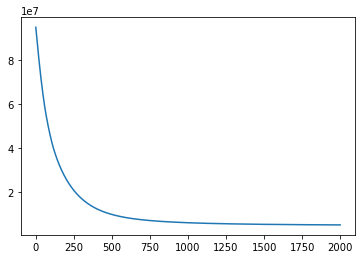

In [13]:
plt.plot(loss_hist)

In [14]:
def get_composition_trajectories(time_step=0.01):
    times_z = torch.arange(0,1,time_step)
    # Take time to appropriate exponent
    times_zk = torch.pow(times_z[:,None], torch.arange(1,pseudo_time_reg_deconv.polynomial_degree + 1,))
    # get the trained params
    base_composition_post_c = pyro.param("unnorm_cell_pop_base_posterior_loc_c").detach().cpu()
    delta_composition_post_ck = pyro.param("unnorm_cell_pop_deform_posterior_loc_ck").detach().cpu()
    # Calculate the deltas for each time point
    delta_cz = torch.matmul(delta_composition_post_ck, times_zk.transpose(-1,-2))
    # normalize
    norm_comp_t = torch.nn.functional.softmax(base_composition_post_c[:,None] + delta_cz, dim=0).numpy().T
    return {"times_z": times_z.numpy(), "norm_comp_t": norm_comp_t}

In [15]:
composition_results = get_composition_trajectories(time_step=0.01)

In [16]:
def plot_composition_trajectories(composition_trajectories):
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(composition_trajectories["times_z"], composition_trajectories["norm_comp_t"])
    ax.set_title("Predicted cell proportions")
    ax.set_xlabel("Pseudotime")
    ax.legend(ebov_dataset.cell_type_str_list,loc='best',fontsize='small')

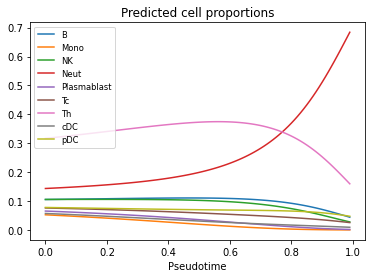

In [17]:
plot_composition_trajectories(composition_results)